In [6]:
import datetime as dt
import pandas as pd
import numpy as np
import pandas_datareader as web
import alphalens as al
import scipy.stats as ss
from scipy.optimize import minimize
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')
style.use('seaborn-poster')

mod_path = '/Users/richard.wuebker/Projects/price_data_utils'
if mod_path not in sys.path:
    sys.path.append(mod_path)
    
from data_loader import DataLoader
from mp_historical_prices import HistoricalPrices

In [2]:
dl = DataLoader(prices_dir='../../price_data_utils/prices', info_dir='../../price_data_utils/info', 
                analysis_date_str='2019-07-31', cached_dir='../../price_data_utils/cached')
dl.load_data()

Prediction Date: 2019-08-02


In [3]:
data = dl.data
data.head()

,mkt_cap,beta,book_value,sector,eps,month_ago,year_ago,prev_date,analysis_date,trade_date,pred_date,volume
ticker,,,,,,,,,,,,
CSCO,237152452608,1.028849,36804000000,Technology,2.882000,54.396709,42.582268,56.470001,55.400002,55.389999,53.250000,17441200.0
SITC,2572780544,0.870377,1499137000,Real Estate,1.043000,13.070000,NaN,14.130000,14.250000,14.100000,14.060000,1716149.0
UAL,23613609984,1.278593,10320000000,Industrials,9.838000,88.449997,81.209999,93.930000,91.910004,90.489998,89.430000,2125300.0
TROW,26710714368,1.029243,6579100000,Financial Services,7.945000,109.050003,113.295105,115.360001,113.389999,110.470001,110.050003,1951700.0
ISRG,59875086336,1.289684,7265300000,Healthcare,10.128999,529.309998,520.359985,531.640015,519.510010,523.950012,513.599976,593300.0


In [43]:
hp = HistoricalPrices(prices_dir='../../price_data_utils/prices', 
                      cached_dir='../../price_data_utils/cached',
                      date_str='2019-08-02')
hp.get_prices()
prices = hp.prices
#prices = prices.set_index('Date')
#prices.index = pd.to_datetime(prices.index)
prices.head()

,Date,High,Low,Open,Close,Volume,Adj Close,ticker
0,2017-05-12,21.299999,20.270000,21.250000,21.10,10933700.0,21.10,GDI
1,2017-05-15,22.299999,21.010000,21.010000,22.02,3487300.0,22.02,GDI
2,2017-05-16,22.410000,22.049999,22.190001,22.10,1289300.0,22.10,GDI
3,2017-05-17,22.510000,21.670000,22.150000,22.10,1583700.0,22.10,GDI
4,2017-05-18,23.629999,21.980000,22.190001,22.50,4075200.0,22.50,GDI


In [63]:
start = pd.to_datetime('2010-01-04')
end = pd.to_datetime('2018-07-25')
prices['Date'] = pd.to_datetime(prices['Date'])
pivoted_prices = prices.pivot(index='Date', columns='ticker', 
                              values='Adj Close').loc[start:end,:].dropna(axis=1)
pivoted_prices.index = pd.to_datetime(pivoted_prices.index)
pivoted_prices.tail()

ticker,A,AA,AAL,AAP,AAPL,ABC,ABMD,ABT,ACC,ACGL,...,XLNX,XOM,XPO,XRAY,XRX,Y,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-19,63.586327,41.560001,37.714115,143.155960,189.003006,83.975754,425.989990,62.733028,40.905827,29.010000,...,67.584396,78.575127,100.620003,44.978554,24.263849,607.469971,77.986092,111.324196,148.949997,51.927254
2018-07-20,63.288963,40.320000,37.466839,142.457001,188.569595,83.131676,423.480011,62.280582,40.292572,29.049999,...,67.111839,77.990677,102.040001,44.671024,24.177124,607.830017,77.966431,110.748932,145.960007,51.741798
2018-07-23,63.160107,41.330002,37.625099,144.444046,188.737030,83.180756,430.899994,62.162552,40.024273,29.040001,...,67.308746,77.990677,103.059998,46.159065,24.186760,612.739990,77.612526,111.978806,146.160004,52.512894
2018-07-24,64.220703,42.490002,37.041531,139.781021,190.106216,82.375931,423.410004,63.342857,38.903172,29.129999,...,66.688522,79.533241,99.250000,46.357475,23.897673,617.520020,76.924385,113.674858,144.059998,50.999981
2018-07-25,65.380424,43.110001,37.773457,140.260284,191.898926,83.200378,430.640015,64.159225,39.123558,29.500000,...,66.914948,80.088943,101.300003,46.416992,23.868767,617.530029,77.337273,116.184204,145.399994,50.287445


In [64]:
spy = web.DataReader('SPY', 'yahoo', start=start, end=end)
spy = spy.drop(spy.index[-1])
spy.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-07-19,280.739990,279.459991,280.309998,280.000000,61412100.0,274.569244
2018-07-20,280.480011,279.500000,279.769989,279.679993,82337700.0,274.255432
2018-07-23,280.429993,279.059998,279.450012,280.200012,47047600.0,274.765350
2018-07-24,282.559998,280.630005,281.790009,281.609985,68026900.0,276.147980
2018-07-25,284.369995,281.279999,281.329987,284.010010,78882900.0,278.501434


In [65]:
spy = spy[['Adj Close']]
spy.columns=['SPY']
spy.head()

,SPY
Date,
2010-01-04,93.675278
2010-01-05,93.923241
2010-01-06,93.989357
2010-01-07,94.386139
2010-01-08,94.700218


In [66]:
p = pd.concat([pivoted_prices, spy], axis=1)
p[['SPY', 'AAPL']]

,SPY,AAPL
Date,,
2010-01-04,93.675278,26.782711
2010-01-05,93.923241,26.829010
2010-01-06,93.989357,26.402260
2010-01-07,94.386139,26.353460
2010-01-08,94.700218,26.528664
2010-01-11,94.832466,26.294640
2010-01-12,93.948021,25.995537
2010-01-13,94.741539,26.362217
2010-01-14,94.997765,26.209538


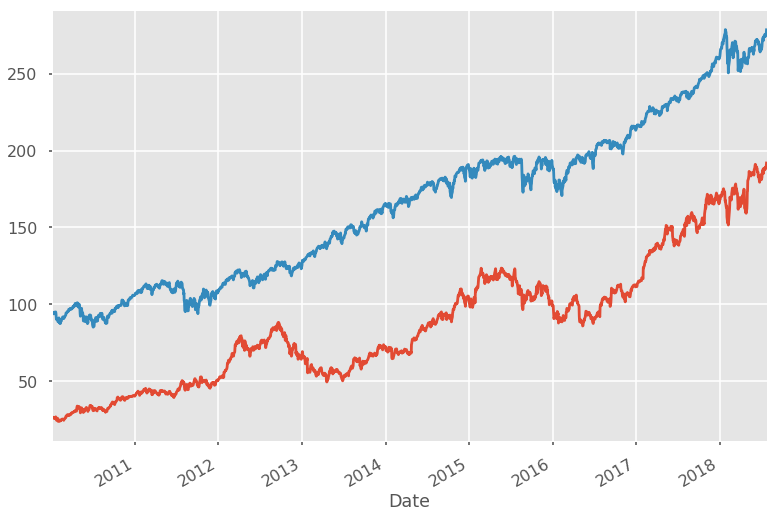

In [67]:
p['AAPL'].plot(label='AAPL')
p['SPY'].plot(label='SPY')

In [68]:
aapl = p['AAPL'].pct_change()[1:]
spy = p['SPY'].pct_change()[1:]


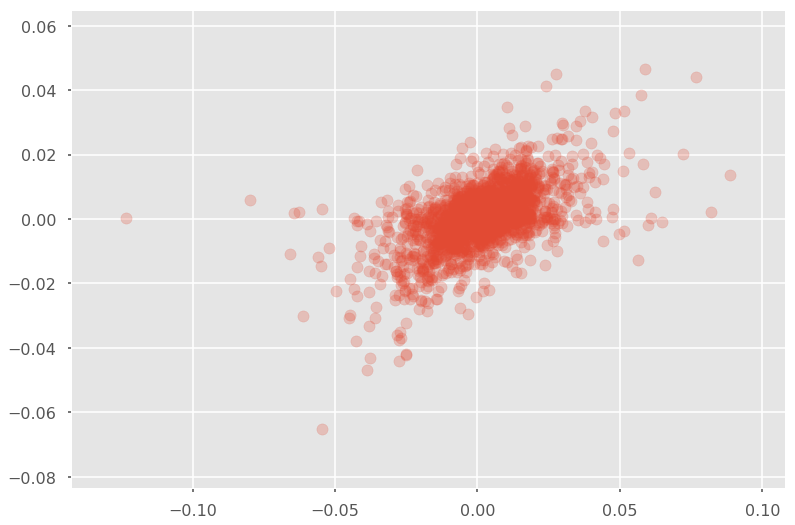

In [69]:
plt.scatter(aapl, spy, alpha=0.25)

In [70]:
beta, alpha, r_value, p_value, std_err = ss.linregress(aapl, spy)

In [71]:
beta

0.329403959555238

In [72]:
alpha

0.0002062810486147137

In [73]:
r_value

0.5637174747943202

In [90]:
noise = np.random.normal(0, 0.003, len(spy))

In [91]:
fake_stock = spy + noise

In [92]:
fake_stock.head()

Date
2010-01-05    0.003057
2010-01-06   -0.000096
2010-01-07    0.002933
2010-01-08    0.004920
2010-01-11    0.000417
Name: SPY, dtype: float64

In [93]:
beta, alpha, r_value, p_value, std_err = ss.linregress(fake_stock, spy)

In [94]:
beta

0.9030510266687034

In [95]:
alpha

5.469673705679181e-05

In [96]:
r_value

0.9527747420872967

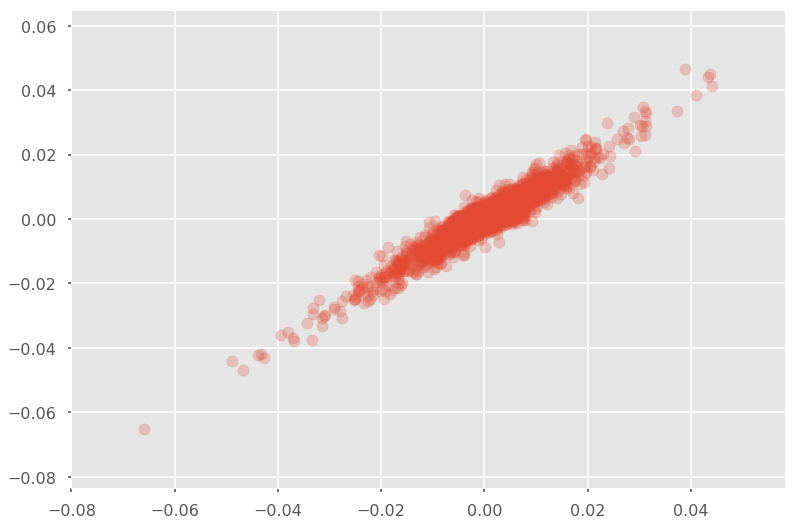

In [97]:
plt.scatter(fake_stock, spy, alpha=0.25)